#  Brain-body-behavior descriptors ME

## Task and reference performance
**Climber-v0** -> climb inbetween two walls; usual performance between 2 and 5

## Descriptors recap
- Brain: (1) one arity functions / n nodes, (2) two arity functions / n nodes
- Body: (1) n active voxels / n voxels, (2) elongation
- Behavior: (1) x-velocity (median of fft), (2) average angle of contact with walls

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from qdax.utils.plotting import plot_2d_map_elites_repertoire
from scipy.stats import ranksums
%matplotlib inline

/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.decl

In [3]:
dfs = []
for sampler in ["all"]:  #, "s1", "s2", "s3"]:  #, "me"]:
    for seed in range(1,2):
        try:
            tmp_df = pd.read_csv(f"../results/me/evo-body-10x10-climber-{sampler}_{seed}.csv")
            tmp_df["sampler"] = sampler
            tmp_df["seed"] = seed
            # tmp_df["iteration"] = list(range(1, len(tmp_df) + 1))
            dfs.append(tmp_df)
        except FileNotFoundError:
            print(sampler, seed)
df = pd.concat(dfs)
df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,sampler,seed
0,1,0.066713,-0.417533,-6.390573,-8.048517,1.171875,4.199219,5.371094,16.229188,2024-05-20 17:25:43.525722,28,all,1
1,2,0.066713,-0.417533,-7.569426,-9.019203,1.171875,5.175781,6.640625,6.398712,2024-05-20 17:25:49.924736,26,all,1
2,3,0.066713,-0.306692,-8.354581,-9.744009,1.171875,6.250000,8.105469,7.339550,2024-05-20 17:25:57.264689,21,all,1
3,4,0.066713,-0.306692,-8.622636,-10.628267,1.171875,6.933594,9.472656,7.040145,2024-05-20 17:26:04.305218,22,all,1
4,5,0.066713,-0.147719,-8.984030,-11.049347,1.171875,7.910156,11.132812,7.702342,2024-05-20 17:26:12.007946,17,all,1


In [4]:
final_df = df[df["iteration"] == max(df["iteration"])]
final_df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,sampler,seed
5109,5110,0.693543,23.715292,94.43778,38.463642,17.578125,48.4375,99.70703,8.568085,2024-05-21 05:31:57.444648,9,all,1


## Fitness results
- no convergence yet, how many more iterations would it require?
- sampling from all repertoires is better in median, but not statistically significant; joint ME follows immediately
- body diversity seems the least important for performance, does it depend on coverage/descriptors?

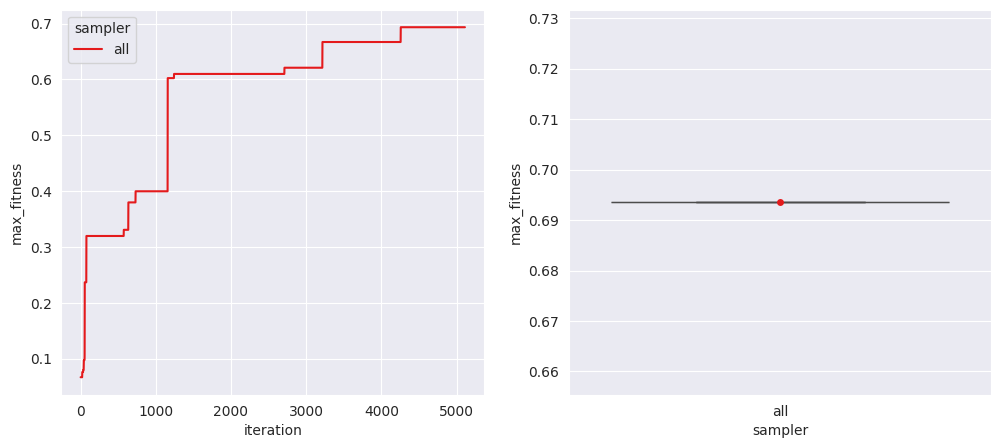

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(df,
             x="iteration",
             y="max_fitness",
             estimator="median",
             errorbar=("pi", 50),
             hue="sampler",
             palette="Set1",
             ax=axs[0]
             )
sns.boxplot(
    final_df,
    x="sampler",
    y="max_fitness",
    hue="sampler",
    palette="Set1",
    boxprops={'alpha': 0.4},
    ax=axs[1]
)
sns.stripplot(final_df,
              x="sampler",
              y="max_fitness",
              hue="sampler",
              palette="Set1",
              dodge=True,
              ax=axs[1])
plt.show()

In [5]:
pairs = []
for s1 in final_df.sampler.unique():
    for s2 in final_df.sampler.unique():
        if s1 != s2 and (s2, s1) not in pairs:
            pairs.append((s1, s2))
            fits1 = final_df[final_df["sampler"] == s1]["max_fitness"].to_list()
            fits2 = final_df[final_df["sampler"] == s2]["max_fitness"].to_list()
            _, p_value = ranksums(fits1, fits2)
            print(f"{s1} vs {s2} -> {p_value}")

all vs s1 -> 0.044609718024939606
all vs s2 -> 0.5838824207703652
all vs s3 -> 0.13559300126630222
s1 vs s2 -> 0.17452534056858338
s1 vs s3 -> 0.8064959405073401
s2 vs s3 -> 0.4624327264504764


## Coverage results
- sampling from repertoire x fosters diversity/coverage in x
- sampling from all repertoires is the second-best option for each, i.e., the best trade-off
- as before, ME has the worst coverage 

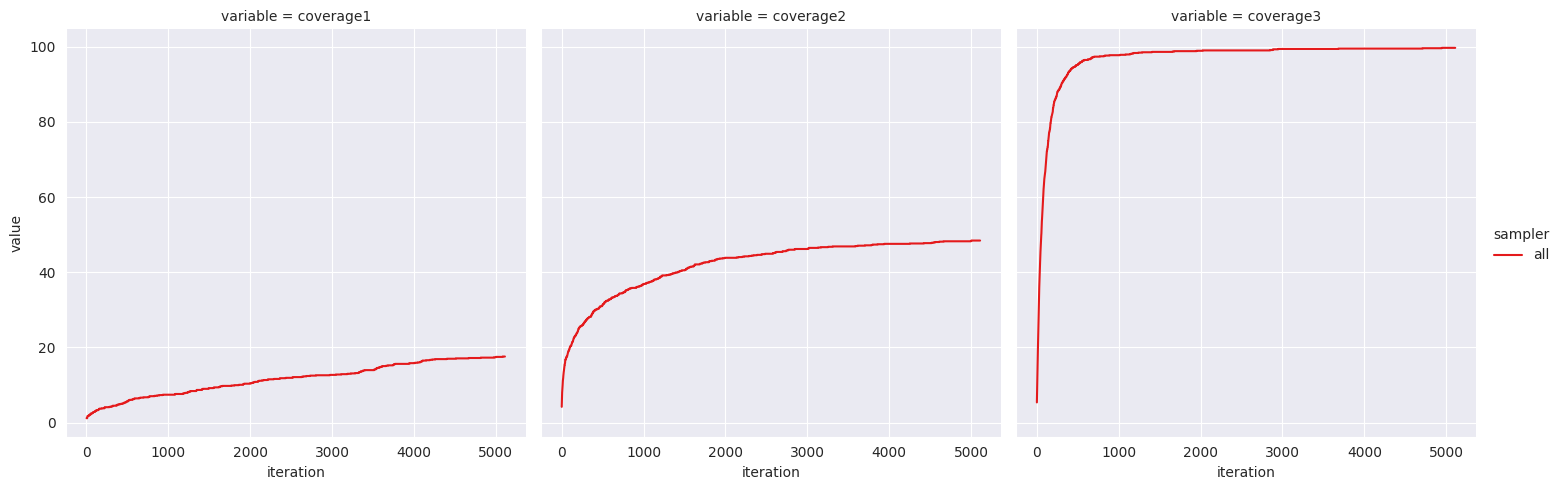

In [6]:
df_wide = pd.melt(df, id_vars=["iteration", "max_fitness", "time", "current_time", "sampler", "seed"],
                  value_vars=["coverage1", "coverage2", "coverage3"])
sns.relplot(df_wide,
            x="iteration",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="line",
            estimator="median",
            errorbar=("pi", 50),
            )
plt.show()

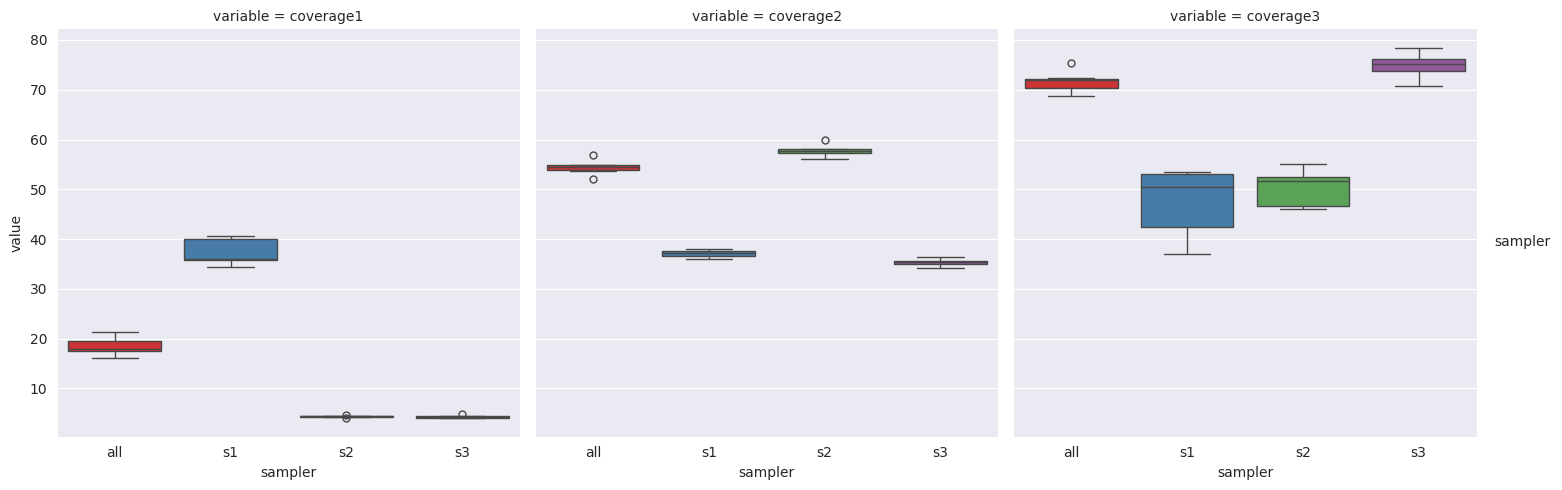

In [7]:
final_df_wide = df_wide[df_wide["iteration"] == max(df_wide["iteration"])]
sns.catplot(final_df_wide,
            x="sampler",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="box",
            )
plt.show()

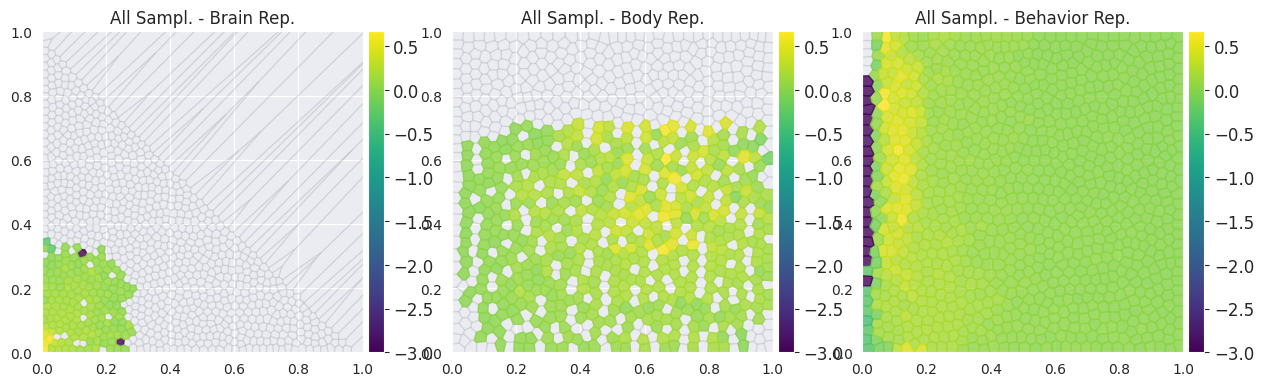

In [7]:
samplers = ["all"]
rep_seed = 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
reps = {
    0: "Brain",
    1: "Body",
    2: "Behavior"
}
sams = {
    "all": "All",
}
min_fit, max_fit = jnp.inf, -jnp.inf
for i, sampler in enumerate(samplers):
    base_path = f"../results/me/evo-body-10x10-climber-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        curr_min_fit, curr_max_fit = min(fitnesses[fitnesses > -jnp.inf]), max(fitnesses)
        if curr_min_fit < min_fit: min_fit = curr_min_fit
        if curr_max_fit > max_fit: max_fit = curr_max_fit

for i, sampler in enumerate(samplers):
    base_path = f"../results/me/evo-body-10x10-climber-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        plot_2d_map_elites_repertoire(centroids, fitnesses, 0, 1, ax=ax, vmin=min_fit, vmax=max_fit)
        ax.set_title(f"{sams[sampler]} Sampl. - {reps[r]} Rep.")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.show()